In [2]:
import re

from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

from tqdm import tqdm
import operator

import networkx as nx
import matplotlib.pyplot as plt

Data preprocessing

In [3]:
def clean_text(text):
    cleaned_text = re.sub('[^ ㄱ-ㅣ가-힣]+',' ',text) # 한국어, 스페이스바를 제외한 모든 문자 제거
    cleaned_text = ' '.join(cleaned_text.split()) # 너무 많은 공백이 생기므로 공백 1개로
    return cleaned_text

def get_nouns(text):
    okt = Okt() # 형태소 분석기
    nouns = okt.nouns(text) # 명사 추출
    nouns = [word for word in nouns if not (word in stopwords)] # 불용어 제거
    nouns = [word for word in nouns if len(word)>1] # 길이가 1 이상만 추출
    return nouns

In [4]:
def clean_tokenizing(data):
    data = data.dropna() # 결측값 제거
    data['내용'] = data['내용'].apply(lambda x: clean_text(x)) # 한국어만 추출
    data['명사'] = data['내용'].apply(lambda x: get_nouns(x)) # 명사만 추출
    
    drop_index_list = [] # 지워버릴 index를 담는 리스트
    for i, row in data.iterrows():
        temp_nouns = row['명사']
        if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
            drop_index_list.append(i) # 지울 index 추가
    data = data.drop(drop_index_list) # 해당 index를 지우기
    data.index = range(len(data))
    return data

In [5]:
def mk_tfidf(data):
    cv = CountVectorizer(max_features=1000, tokenizer=get_nouns) # data의 tf-idf 구축, tokenizer로 get_nouns 사용
    tdm = cv.fit_transform(data['내용']) # 위의 파라미터 수에 맞게 tdm 생성
    dataset = pd.DataFrame(data=tdm.todense(),columns=cv.get_feature_names())
    return dataset

In [6]:
def mk_input(tf_idf):
    column_list = list(tf_idf.columns)
    word_length = len(column_list)

    # 각 단어쌍의 빈도수를 저장할 dictionary 생성
    count_dict = {}

    for doc_number in tqdm(range(len(tf_idf)), desc='단어쌍 만들기 진행중'):
        tmp = tf_idf.loc[doc_number]           # 현재 문서의 단어 출현 빈도 데이터를 가져온다.
        for i, word1 in enumerate(column_list):
            if tmp[word1]:              # 현재 문서에 첫번째 단어가 존재할 경우
                for j in range(i + 1, word_length):
                    if tmp[column_list[j]]:              # 현재 문서에 두번째 단어가 존재할 경우
                        count_dict[column_list[i], column_list[j]] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

    # count_list에 word1, word2, frequency 형태로 저장할 것이다.
    count_list = []

    for words in count_dict:
        count_list.append([words[0], words[1], count_dict[words]])

    # 단어쌍 동시 출현 빈도를 DataFrame 형식으로 만든다.
    df = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
    df = df.sort_values(by=['freq'], ascending=False)
    df = df.reset_index(drop=True)
    return df

감성사전에 따른 가중치 추가해야함

In [7]:
def draw(df, keyword, length):
    font_family='NanumSquareRound'
    print(keyword, length)
    dataset = df[df['word1'].isin(keyword)]
    print(dataset)
    G_centrality = nx.Graph()

    # 빈도수가 20000 이상인 단어쌍에 대해서만 edge(간선)을 표현한다.
    for ind in list(dataset.index)[:length]:
        G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight=int(dataset['freq'][ind]))

    dgr = nx.degree_centrality(G_centrality)        # 연결 중심성
    btw = nx.betweenness_centrality(G_centrality)   # 매개 중심성
    cls = nx.closeness_centrality(G_centrality)     # 근접 중심성
    egv = nx.eigenvector_centrality(G_centrality)   # 고유벡터 중심성
    pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

    sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
    sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
    sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
    sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
    sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

    G = nx.Graph()
    
    for i in range(len(sorted_pgr)): # 페이지 랭크에 따른 노드 추가, 노드 사이즈는 연결 중심성으로 결정
        G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1],color='r')

    for ind in list(dataset.index)[:length]: # 같이 나온 빈도수가 많을 수록 가까움
        G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])
        
    words = list(G.nodes)
    sent_points = []
    word_points = {}
    for word in words:
        try:
            sent_point = float(sent[sent['단어'] == word]['points'].values)
            word_points[word] = sent_point
            sent_points.append(sent_point)
        except:
            word_points[word] = 0
            sent_points.append(0) 
    
    #colors = list(r)

    # 노드 크기 조정
    sizes = [G.nodes[node]['nodesize'] * 5000+1000 for node in G] 

    # 옵션
    options = {
        'edge_color': '#000000',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
        'cmap' : 'jet',
        'node_color' : sent_points,
        'alpha' : 0.5
    }


    plt.figure(figsize=(8,5))
    nx.draw(G, node_size=sizes,
            pos=nx.spring_layout(G, k=3.5, iterations=100), **options, font_family=font_family)  # font_family로 폰트 등록
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")
    plt.show()
    return word_points

연관 출현 빈도 분석결과 저장시

In [23]:
file_path='C:/Users/hyunsoo/study/ds_project/crawler/박채희/crawler/환경오염.csv' # 파일 수정필요
stopwords_path = './data/stopwords.txt'
sent = pd.read_csv('./data/dict.csv',encoding='cp949')
with open(stopwords_path,'r') as op:
    stopwords = op.readlines()
    stopwords = stopwords[0].split(',')

data = pd.read_csv(file_path, encoding='cp949',index_col = 0)
data = clean_tokenizing(data)
tf_idf = mk_tfidf(data)
words_freq = mk_input(tf_idf)
words_freq.to_csv('data/words_freq.csv',encoding='cp949')

단어쌍 만들기 진행중: 100%|████████████████████████████████████████████████████████| 1105/1105 [10:33<00:00,  1.74it/s]


In [2]:
words_freq = pd.read_csv('./data/words_freq.csv',encoding='cp949')
sent = pd.read_csv('./data/dict.csv',encoding='cp949')

['코인', '테슬라'] 20
         Unnamed: 0 word1 word2  freq
52633         52633    코인    화폐    56
59643         59643   테슬라    환경    52
66178         66178   테슬라  환경오염    48
68538         68538   테슬라    현재    47
73452         73452    코인    환경    45
...             ...   ...   ...   ...
2482639     2482639    코인  홈페이지     1
2482640     2482640    코인    환기     1
2482641     2482641    코인    훼손     1
2482929     2482929   테슬라    풍력     1
2482930     2482930   테슬라    흡수     1

[216 rows x 4 columns]


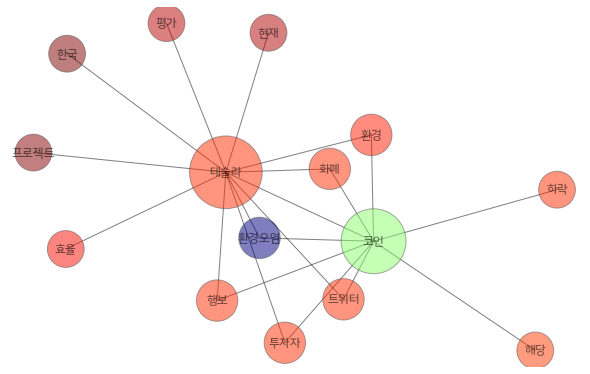

{'테슬라': 0.0034647694741412, '코인': -0.4003071999232327, '화폐': 0, '환경': 0.0234662641354019, '환경오염': -1.0, '트위터': 0, '행보': 0, '투자자': 0, '현재': 0.1114123860276696, '평가': 0.1010959641487919, '효율': 0.0371234619324266, '프로젝트': 0.1534236028570561, '한국': 0.1626167059332343, '하락': 0, '해당': -0.0106338073469777}


In [11]:
print(draw(words_freq,['코인','테슬라'],20))

C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


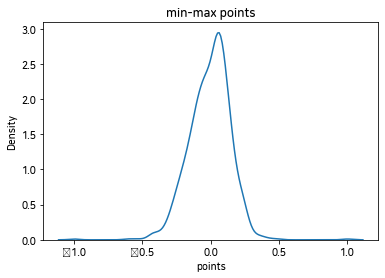

In [47]:
import seaborn as sns

sns.kdeplot(sent['points'])
plt.title('min-max points')
plt.show()

<AxesSubplot:xlabel='회귀계수', ylabel='Density'>

C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


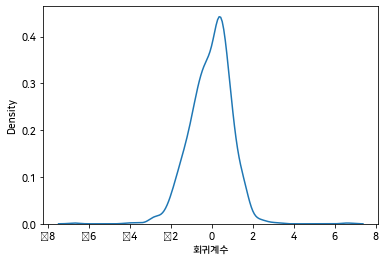

In [48]:
sns.kdeplot(sent['회귀계수']/sent['회귀계수'].std())

In [28]:
sent[sent['단어'].isin(['친환경'])]

,Unnamed: 0,단어,회귀계수,points
0,840,친환경,8.320163,1.0


In [13]:
sent[sent['회귀계수']<0][:20]

,Unnamed: 0,단어,회귀계수,points
506,977,환경오염,-8.457512,-1.000000
507,773,지구,-5.106258,-0.603551
508,220,리플,-4.510213,-0.533040
509,627,의약품,-3.697882,-0.436942
510,515,쓰레기,-3.685172,-0.435439
511,263,문제,-3.657819,-0.432203
512,296,발생,-3.574811,-0.422383
513,39,건설,-3.514378,-0.415234
514,767,중앙,-3.491112,-0.412482
515,853,코인,-3.388198,-0.400307


In [14]:
sent[sent['회귀계수']>0][:20]

,Unnamed: 0,단어,회귀계수,points
0,840,친환경,8.320163,1.000000
1,521,아웃,4.020127,0.483013
2,584,옷,3.538164,0.425068
3,337,보전,3.162151,0.379860
4,958,형,3.123427,0.375204
5,795,차,2.977596,0.357671
6,9,가장,2.848457,0.342145
7,420,생활,2.628966,0.315756
8,871,텀블러,2.612707,0.313801
9,163,달,2.572218,0.308933


* * *

In [11]:
news = pd.concat([pd.read_csv('Data/친환경_news.csv',encoding='cp949'),pd.read_csv('Data/환경오염_news.csv',encoding='cp949')])

In [9]:
file_path='C:/Users/hyunsoo/study/ds_project/crawler/박채희/crawler/환경오염.csv' # 파일 수정필요
stopwords_path = './data/stopwords.txt'
sent = pd.read_csv('./data/dict.csv',encoding='cp949')
with open(stopwords_path,'r') as op:
    stopwords = op.readlines()
    stopwords = stopwords[0].split(',')

In [18]:
#news_data = pd.read_csv(file_path, encoding='cp949',index_col = 0)
news_data = clean_tokenizing(news)
news_tf_idf = mk_tfidf(news_data)
news_words_freq = mk_input(news_tf_idf)

<ipython-input-13-0fca09fa8b33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['내용'] = data['내용'].apply(lambda x: clean_text(x)) # 한국어만 추출
<ipython-input-13-0fca09fa8b33>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['명사'] = data['내용'].apply(lambda x: get_nouns(x)) # 명사만 추출
단어쌍 만들기 진행중: 100%|████████████████████████████████████████████████████████| 1131/1131 [08:41<00:00,  2.17it/s]


In [20]:
news_words_freq.to_csv('news_words_frea.csv',encoding='cp949')

In [10]:
community = pd.concat([pd.read_csv('Data/친환경_community.csv',encoding='cp949'),pd.read_csv('Data/환경오염_community.csv')])
community_data = clean_tokenizing(community)
community_tf_idf = mk_tfidf(community_data)
community_words_freq = mk_input(community_tf_idf)
community_words_freq.to_csv('community_words_freq.csv',encoding='cp949')

단어쌍 만들기 진행중: 100%|████████████████████████████████████████████████████████| 3022/3022 [08:05<00:00,  6.22it/s]


In [11]:
sns = pd.concat([pd.read_csv('Data/친환경_sns.csv'),pd.read_csv('Data/환경오염_sns.csv')])
sns_data = clean_tokenizing(sns)
sns_tf_idf = mk_tfidf(sns_data)
sns_words_freq = mk_input(sns_tf_idf)
sns_words_freq.to_csv('sns_words_freq.csv',encoding='cp949')

<ipython-input-4-0fca09fa8b33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['내용'] = data['내용'].apply(lambda x: clean_text(x)) # 한국어만 추출
<ipython-input-4-0fca09fa8b33>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['명사'] = data['내용'].apply(lambda x: get_nouns(x)) # 명사만 추출
단어쌍 만들기 진행중: 100%|██████████████████████████████████████████████████████████| 978/978 [01:12<00:00, 13.53it/s]
